In [3]:
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import os

## Zbudowanie pliku vrt

Komenda w takiej postaci korzysta ze znaku globalnego wskazującego na wszystkie pliki zaczynające się na 0

Vrt jest nam potrzebny aby próbkować wszystkie warstwy na raz

```bash
gdalbuildvrt -separate data.vrt 0*
```

## import danych rastrowych

In [4]:
rasters = rio.open("dane/rasters.vrt") 
vector = gpd.read_file("dane/proby.gpkg")

## nazwy plików (bez ścieżki i rozszerzenia)

In [5]:
rasters.files # 1 plik to rasters.vrt
colnames = [os.path.splitext(os.path.basename(file))[0] for file in rasters.files[1:]]

## próbkowanie rastra


1. Próbkowanie wymaga pary koordynat w formie krotki. Geopandas ma bardzo dużo różnych metod, ale tej akurat nie. Do zbudowania listy wspórzędnych w postaci krotki użyjemy metody `apply`, która zastosuje dla każdego wiersza bazy danych **vector** funkcję anonimową: `lambda x: (x.x, x.y)`
2. Następnie zbudujemy sobie listę tablic np (np.arrays) zawierającą wyniki próbkowania dla każdego punktu. Niestety `sample` to generator, i trzeba to robić w formie listy składanej
3. Zamieniamy wynik próbkowania w DataFrame, jako nazwy kolumn podajemy **colnames** i na końcu dołaczamy vector z wartościami i geometrią punktów.


In [6]:
coords = vector.geometry.apply(lambda x: (x.x, x.y))
samples = [x for x in rasters.sample(coords)]
samples = gpd.GeoDataFrame(samples,columns=colnames).join(vector)

> Ten zestaw czynności jest nadmiernie złożony, alternatywnie wykorzystać zewnętrzne oprogramowanie, np _SAGA GIS _lub użyć zbioru danych **"proby_s.gpkg"**

In [10]:
samples = gpd.read_file("dane/proby_s.gpkg")

## PCA dla danych rastrowych

Trening PCA dla próbki i transformacja dla całego zbioru danych, typowe postępowanie dla dużych zbiorów danych. Dodatkowo dane trzeba transformować dla próby. 

1. Trenujemy na podstawie numpy.array a nie pandas
2. Dane muszą być przeskalowane
3. Scaler i pca zachowujemy do ponownej analizy

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [25]:
dane_s = samples.iloc[:,:8].values
scaler = StandardScaler().fit(dane_s)
scaled_s = scaler.transform(dane_s)
pca = PCA(whiten=True).fit(scaled_s)


In [26]:
pca.explained_variance_ratio_

array([0.42324179, 0.22441342, 0.11997391, 0.09157551, 0.06371564,
       0.04043654, 0.02158596, 0.01505724])

### Udział wariancji i egienvectors

1. 65% wariancji wyjaśnione przez dwie składowe
2. Pierwsza PC (0) skorelowana ze zmiennymi 5-8 czyli charakterystyczmi dla miasta
3. Duga z szorstkością, zielenią odległością od wody i różnicą wysokości

## Zastosowanie PCA dla całego rastra

1. Dane należy spłaszczyć, po dalszych wymiarach. Najprościej ż użyciem reshape.(x0,x1*x2)
2. Prędzej niż później (bardziej, natychmiast niż prędzej) będziemy mieli dane z pustkami. Trzeba je usunąć ale niezbyt trwale
3. dane trzeba zrotować (transformacja) bo w takiej postaci dane przyjmują narzędzia `sklearn`
4. Spłaszczanie polega na tym, że zachowujemy 0 wymiar a spłaszczenie odbywa się na dwóch ostatnich. Na końcu T.

In [49]:
dane_r = rasters.read()
s = dane_r.shape # to zachowujemy
flat_r = dane_r.reshape(s[0],s[1]*s[2]).T

1. trzeba zbudować selector zawierający niepuste wartości
2. Następnie przeprowadzić skalowanie i transformację PCA już na danych dla całego rastra

In [47]:
notnull = ~(np.isnan(flat_r).any(1))
sub_flat_r = flat_r[notnull]
scaled_r = scaler.transform(sub_flat_r)
pc_r = pca.transform(scaled_r)

No i mamy problem, bo nasze pca to jakieś dziwne 79715 danych co nijak nie da się zmienić w raster. Trzeba przywrócić oryginalne wymary

1. Tworzymy pusty sprzed selekcji, używając wymiarów zbioru **flat_r**. 
2. selekcjonujemy niepuste wiersze i wpisujemy w nie wyniki pca
3. Transformujemy dane (zamieniamy wiersze z kolumnami)
4. Przywracamy oryginalne wymiary

In [53]:
pc_rf = np.full(flat_r.shape,np.nan)
pc_rf[notnull] = pc_r
pc_rf = pc_rf.T
pc_rf = pc_rf.reshape(s[0],s[1],s[2])

## Wizualizacja wynikow PCA

Text(0.5, 1.0, 'PC 3')

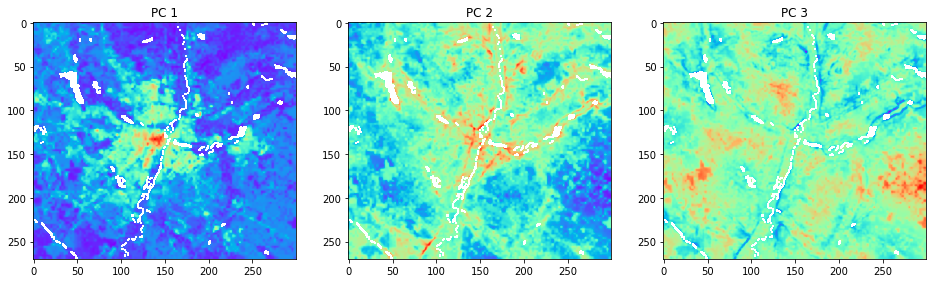

In [91]:
fig,axes = plt.subplots(ncols=3,figsize=(16,6))
axes[0].imshow(pc_rf[0],cmap="rainbow")
axes[1].imshow(pc_rf[1],cmap="rainbow")
axes[2].imshow(pc_rf[2],cmap="rainbow")
axes[0].set_title("PC 1")
axes[1].set_title("PC 2")
axes[2].set_title("PC 3")


In [84]:
pd.DataFrame(pca.components_,columns=colnames)
#pd.DataFrame(pca.components_,columns=colnames).write_excel("components.xls")

,01_roughness,02_green,03_distwaters,04_terange,05_imperm,06_highbuildup,07_buildup,08_road_dens
0,-0.302338,-0.331701,-0.022646,-0.105875,0.485152,0.389493,0.467421,0.425775
1,0.489653,0.477871,-0.417434,0.424087,0.135054,0.272530,0.123278,0.264704
2,0.412432,0.353586,0.616965,-0.512287,0.095811,0.140517,0.058788,0.171500
3,-0.100777,-0.066111,0.649617,0.706003,-0.097764,0.230567,-0.038098,0.029346
4,0.113611,0.089295,0.140148,0.194878,0.406829,-0.618136,0.540707,-0.285543
5,-0.084291,0.018307,0.052489,0.085279,0.093535,-0.551499,-0.336614,0.745871
6,0.678342,-0.719035,-0.006014,0.035700,-0.110038,-0.054089,0.026133,0.076250
7,-0.091733,0.083069,-0.012467,-0.039233,-0.735720,-0.109303,0.595866,0.273317


## Zapis wyników do pliku 

1. Aktualizacja profilu rastra
2. Zapis warstw w pętli

In [88]:
profile = rasters.profile
profile['driver'] = 'GTiff'
profile['count']=1
for i,raster in enumerate(pc_rf):
    pca_rasters = rio.open(f'pca_{i+1}.tif','w', **profile)
    pca_rasters.write(raster.astype('float64'),1)
    pca_rasters.close()

In [87]:
profile

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 300, 'height': 270, 'count': 8, 'crs': CRS.from_wkt('PROJCS["Transverse Mercator",GEOGCS["grs80",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",19],PARAMETER["scale_factor",0.9993],PARAMETER["false_easting",500000],PARAMETER["false_northing",-5300000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(100.0, 0.0, 345000.0,
       0.0, -100.0, 520000.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True}